In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
!pip install fastai > /dev/null

### Read kaggle dataset path

In [4]:
from fastai.vision.all import *

path = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/')
train_path = path/"train"
validation_path = path/"val"
test_path = path/"test"

### Verify dataset path

In [5]:
# Verify that train_path and valid_path are directories
assert train_path.is_dir(), f"{train_path} is not a directory"
assert validation_path.is_dir(), f"{validation_path} is not a directory"
assert test_path.is_dir(), f"{test_path} is not a directory"

### Convert dataset to FastAi DataBlock:

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

**Verify datablock contains only data for training/validation datasets**

In [7]:
# Get the path object of the root directory of the dataset
dataset_path = dls.path
# Check that the training and validation directories exist
train_dir = path/train_path
valid_dir = path/validation_path
assert train_dir.is_dir() and valid_dir.is_dir(), "Training or validation directory does not exist"
# Check that the training and validation directories contain only directories
assert all(p.is_dir() for p in train_dir.iterdir()), "Training directory contains non-directory files"
assert all(p.is_dir() for p in valid_dir.iterdir()), "Validation directory contains non-directory files"

Show Batch of 16 images from training/validation dataset we created above using the datablock

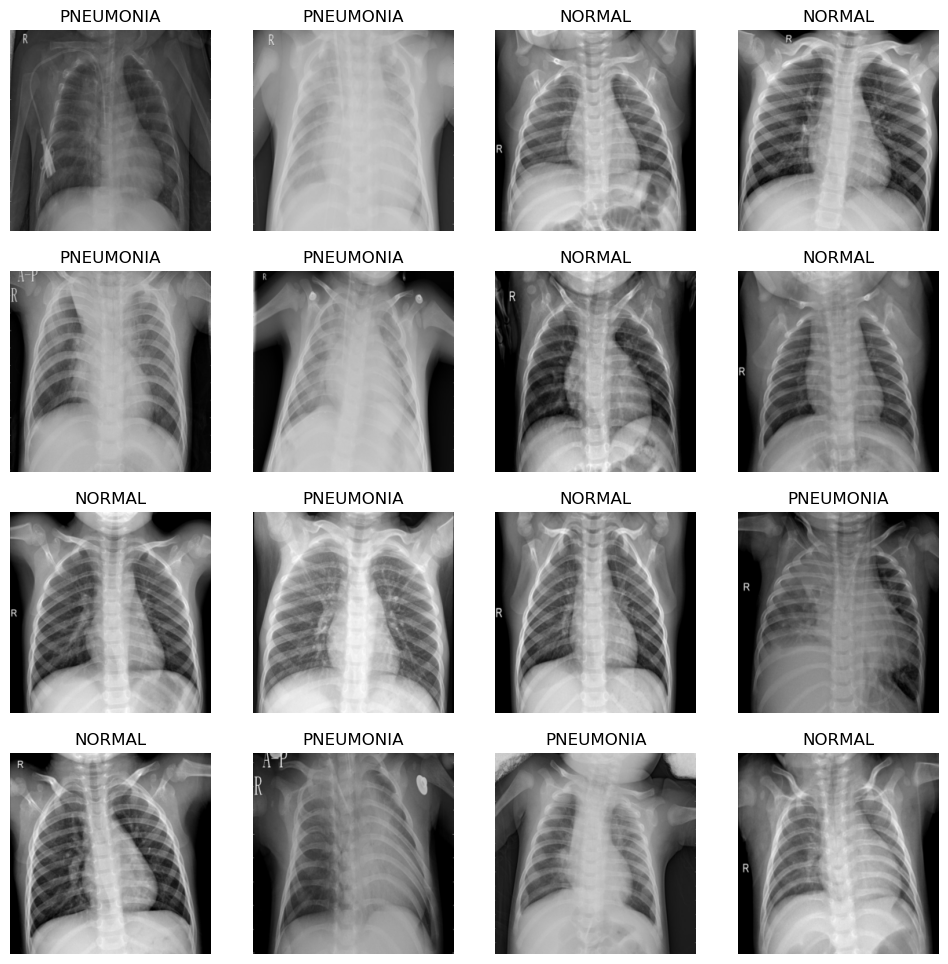

In [8]:
dls.show_batch(max_n=16)

In [9]:
learn = vision_learner(dls, resnet50, metrics=[error_rate, accuracy])

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Get the default loss function / optimizer function 

In [10]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [11]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

Use `lr_find` to try to find the best learning rate



SuggestedLRs(valley=0.0014454397605732083)

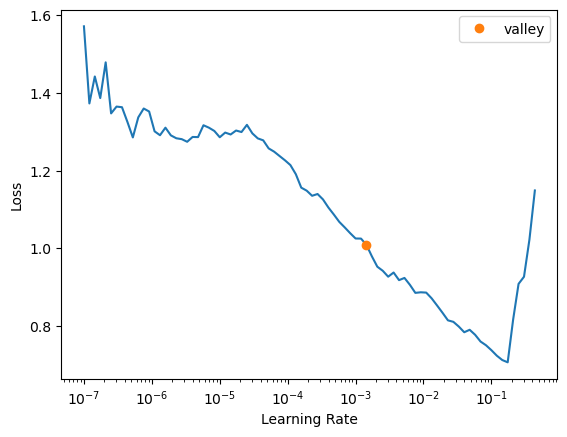

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.155188,1.294507,0.437500,0.562500,05:20


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.070216,0.009985,0.000000,1.000000,05:19
1,0.026309,0.095448,0.062500,0.937500,05:22
2,0.003979,0.094301,0.062500,0.937500,05:20


### plot metrics

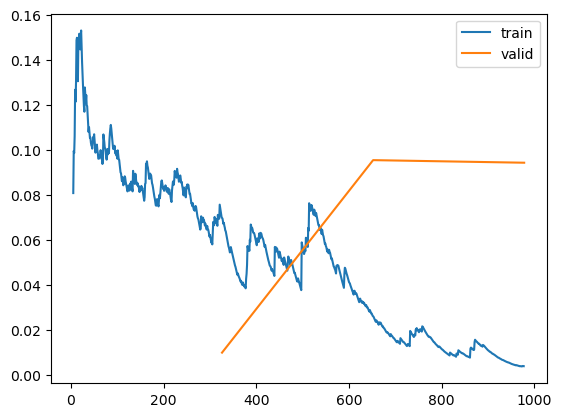

In [14]:
learn.recorder.plot_loss()

Some configurtions to debug
When predicting on an image learn.predict returns a tuple (class, class tensor and [probabilities of each class]).In this dataset there are only 2 classes `No Pneumothorax` and `Pneumothorax` hence the reason why each probability has 2 values, the first value is the probability whether the image belongs to class 0 or `No Pneumothorax` and the second value is the probability whether the image belongs to class 1 or `Pneumothorax`

In [15]:
tta = learn.tta(use_max=True)

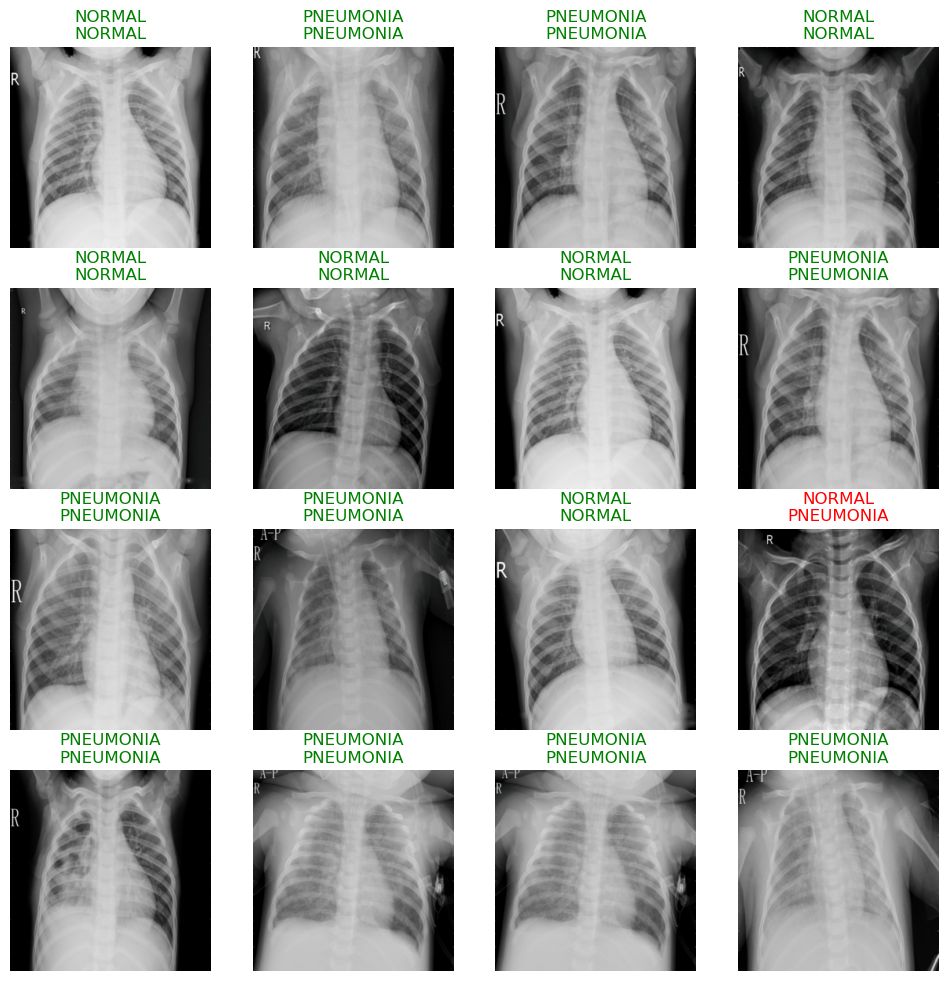

In [16]:
learn.show_results(max_n=16)

### Result Interpretation
This very usfuel function when things goes wrong you can verify manually which label goes incorrect
Lets get top 10 images losses

In [17]:
interp = Interpretation.from_learner(learn)

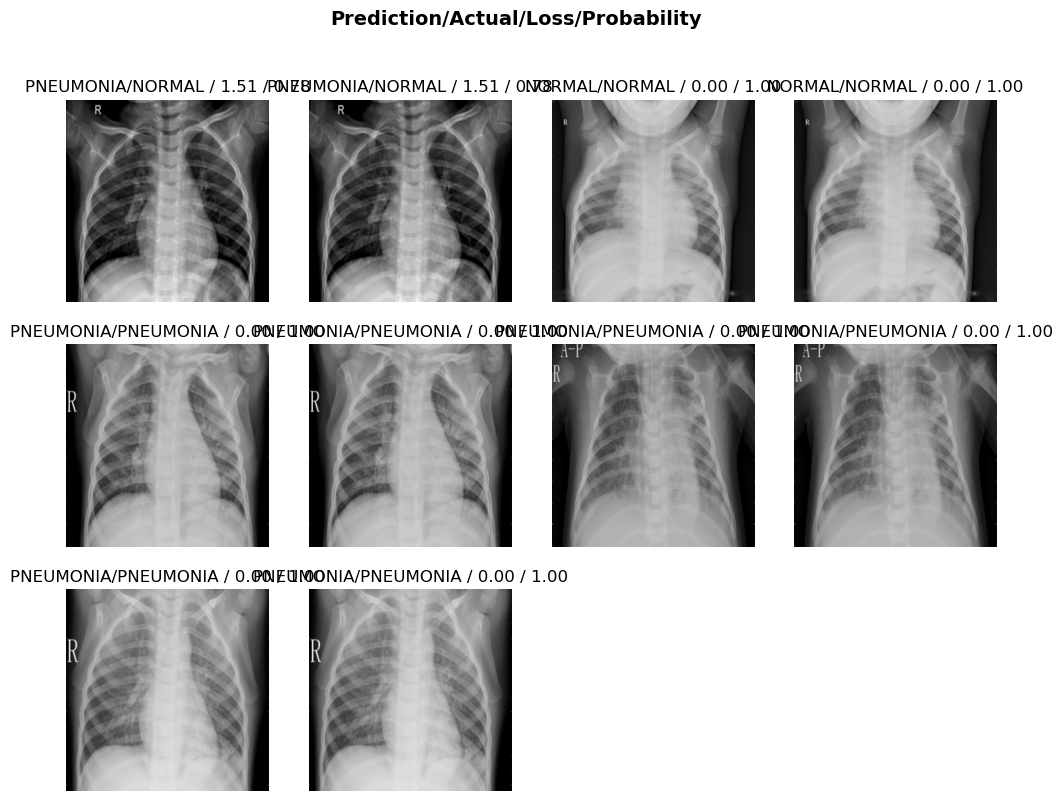

In [18]:
interp.plot_top_losses(10)


### Result Evaluation

Medical models are predominantly high impact so it is important to know how good a model is at detecting a certain condition.

This model has an accuracy of 56%. Accuracy can be defined as the number of correctly predicted data points out of all the data points. However in this context we can define accuracy as the probability that the model is correct and the patient has the condition PLUS the probability that the model is correct and the patient does not have the condition

There are some other key terms that need to be used when evaluating medical models:

False Positive & False Negative

False Positive is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present

False Negative is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present

Sensitivity & Specificity

Sensitivity or True Positive Rate is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives
Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition

Specificity or True Negative Rate is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives


**Confusion Matrix**

The confusion matrix is plotted against the `validation` dataset


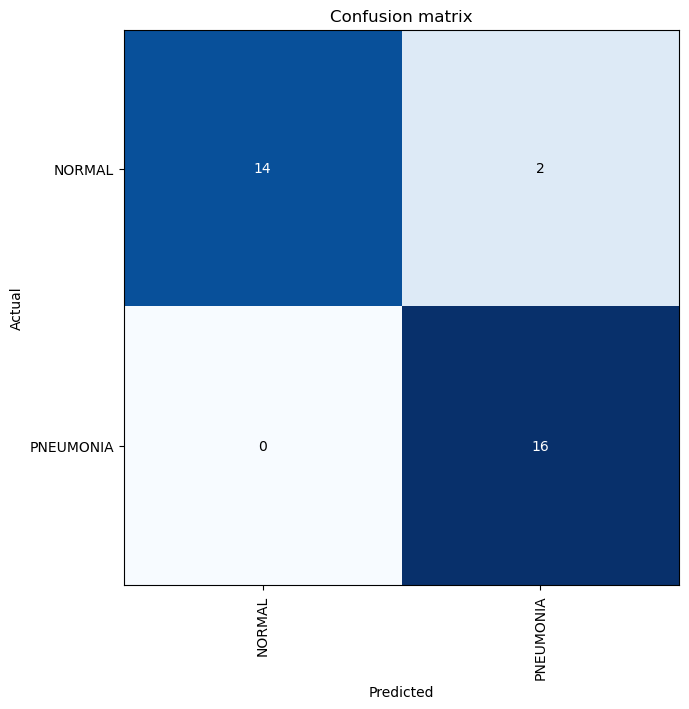

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

Yaaaay!!, seems our model works very well , not overfitting , and predict classes for validation set correctly 100%

![](https://i.gifer.com/S3IK.gif)


However, one thing to notice here the validation set is too small to judge if this model works prefect or not. one way todo that is to split the training dataset into training and validation using fastai `RandomSplitter` function.

![](https://i.gifer.com/S0S.gif)

In [20]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

14 2 0 16


Note that `Sensitivity = True Positive/(True Positive + False Negative)`


In [21]:
sensitivity = tp/(tp + fn)
sensitivity

1.0

### Run On test dataset

In [22]:
def get_test_label(fn):
    return fn.parent.name

test_dl = dls.test_dl(get_image_files(test_path), num_workers=0, with_labels=True, item_tfms=Resize(256))
test_dl.dataset.label_func = get_test_label

result = learn.validate(dl=test_dl)

In [23]:
result

(#3) [1.1550947427749634,0.2291666716337204,0.7708333134651184]